In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Pastikan file 'processed_kelulusan.csv' ada di direktori yang sama
try:
    df = pd.read_csv("processed_kelulusan.csv")
except FileNotFoundError:
    print("Error: processed_kelulusan.csv tidak ditemukan.")
    exit()

X = df.drop("Lulus", axis=1)
y = df["Lulus"]

# Penskalaan (Standardization)
sc = StandardScaler()
Xs = sc.fit_transform(X)

# Pembagian data dua tahap: Train (70%), Val (15%), Test (15%)
# 1. Pisahkan 15% untuk Test Set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    Xs, y, test_size=0.15, stratify=y, random_state=42)

In [2]:
# Perbandingan: 15% / 85% ≈ 0.1765
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=(0.15/0.85), stratify=y_train_val, random_state=42)

print(f"Shape Data:\nTrain: {X_train.shape}\nValidation: {X_val.shape}\nTest: {X_test.shape}")
print("-" * 50)

Shape Data:
Train: (6, 5)
Validation: (2, 5)
Test: (2, 5)
--------------------------------------------------


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Inisialisasi model Sequential
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)), # Input shape sesuai jumlah fitur
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # Output 1 neuron dengan Sigmoid untuk klasifikasi biner
])

# Kompilasi model
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy", "AUC"])

print("Model Summary:")
model.summary()
print("-" * 50)


Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 737 (2.88 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

--------------------------------------------------


In [4]:
es = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

print("Memulai Training Model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)
print("Training Selesai.")
print("-" * 50)

Memulai Training Model...
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - AUC: 0.5556 - accuracy: 0.5000 - loss: 0.7024 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.6054
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - AUC: 0.6667 - accuracy: 0.8333 - loss: 0.6312 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.5953
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - AUC: 0.5556 - accuracy: 0.5000 - loss: 0.6741 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.5860
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - AUC: 1.0000 - accuracy: 0.8333 - loss: 0.6212 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.5768
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - AUC: 1.0000 - accuracy: 0.8333 - loss: 0.6054 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.5690
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - AUC: 1.0000 - accuracy: 1.0000 - loss: 0.6350 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.5615
Epoch 7/100
1/1 ━━━━━━━

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

print("Evaluasi di Test Set:")
# Evaluasi metrik loss, akurasi, dan AUC
loss, acc, auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}, Test AUC: {auc:.4f}")

# Prediksi probabilitas dan konversi ke kelas biner (threshold 0.5)
y_proba = model.predict(X_test).ravel()
y_pred = (y_proba >= 0.5).astype(int)

# Tampilkan Confusion Matrix dan Classification Report (dengan F1-score)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report (F1, Precision, Recall):")
print(classification_report(y_test, y_pred, digits=3))
print("-" * 50)


Evaluasi di Test Set:
Test Loss: 0.0916, Test Accuracy: 1.0000, Test AUC: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

Confusion Matrix:
[[1 0]
 [0 1]]

Classification Report (F1, Precision, Recall):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000     1.000     1.000         2

--------------------------------------------------


Learning curve telah disimpan sebagai 'learning_curve.png'.
--------------------------------------------------


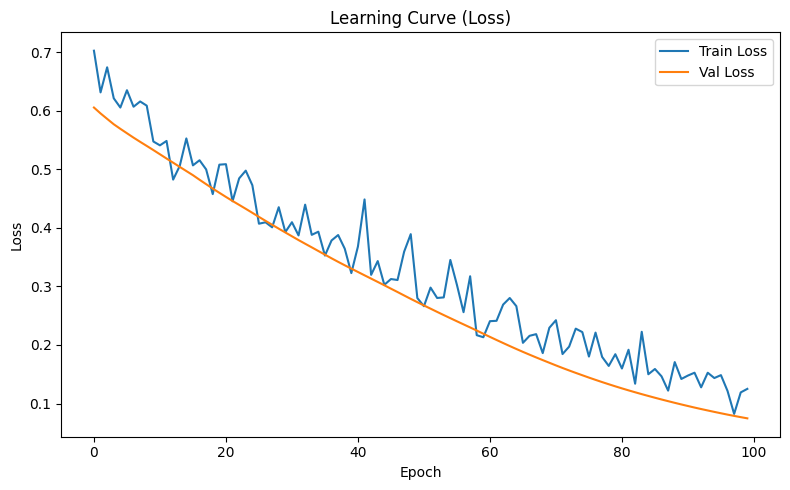

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve (Loss)")
plt.legend()
plt.tight_layout()
plt.savefig("learning_curve.png", dpi=120)
# plt.show() # Uncomment jika dijalankan di environment interaktif
print("Learning curve telah disimpan sebagai 'learning_curve.png'.")
print("-" * 50)